In [1]:
import pandas as pd
import utils
import warnings
import os
import skimage.util
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
genes = ["CEP72", "MTMR9", "SPATA7", "YAP1", "RBM26", "SSBP1", "IL20RB"]

color_discrete_map = {
    "same_plate": "rgb(213, 94, 0)",
    "different_plates": "rgb(0, 158, 115)",
}

symbol_map = {
    "same_row_or_column": "x",
    "different_rows_and_columns": "circle",
}

### Read Profiles

In [3]:
orf_metadata_df = pd.read_csv(
    "../00.download-and-process-annotations/output/orf_metadata.tsv.gz",
    sep="\t",
    usecols=["Metadata_JCP2022", "Metadata_Symbol"],
)

orf_profiles_with_feature_names_df = utils.consensus(
    pd.read_parquet("../profiles/profiles_wellpos_cc_var_mad_outlier_orf.parquet")
    .merge(orf_metadata_df, on="Metadata_JCP2022", how="inner")
    .query('Metadata_Symbol in @genes'),
    "Metadata_Symbol",
)

orf_profiles_with_feature_names_df.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_4,BR00123509,L20,JCP2022_911211,IL20RB,-0.563251,-0.862735,0.445112,-0.414350,0.380735,...,0.529176,0.514146,0.518515,0.506228,0.494304,0.504328,0.507001,0.525635,0.502346,0.501010
1,source_4,BR00123512,L20,JCP2022_914885,CEP72,0.548199,0.188778,-0.950712,0.300605,-1.119493,...,0.447367,0.496191,0.434973,0.455197,0.427364,0.439026,0.452588,0.478226,0.435276,0.448613
2,source_4,BR00123517,K06,JCP2022_903759,MTMR9,-0.401887,-0.809722,0.246457,-0.187846,0.432983,...,-1.072471,-1.122554,-1.081995,-1.098696,-1.092506,-1.062355,-1.086086,-1.069842,-1.079226,-1.081295
3,source_4,BR00123947,D09,JCP2022_911603,RBM26,-1.703838,-1.663814,-0.599653,-1.604465,-0.291192,...,-0.687624,-0.757461,-0.688682,-0.679659,-0.712527,-0.698766,-0.687573,-0.661167,-0.694949,-0.696891
4,source_4,BR00123962,N22,JCP2022_901487,SSBP1,-1.444015,-1.606282,-1.161384,0.970663,-0.894243,...,-1.039182,-0.935711,-1.041095,-1.040212,-1.059501,-1.049994,-1.063058,-1.069612,-1.033122,-1.060136


In [4]:
feature_names = utils.get_featurecols(orf_profiles_with_feature_names_df)

feature_name_interpretation_df = pd.DataFrame()

for feature_name in feature_names:
    df = pd.DataFrame(utils.parse_cp_features(feature_name), index=[0])
    feature_name_interpretation_df = pd.concat([feature_name_interpretation_df, df], ignore_index=True)

feature_name_interpretation_df.head()

,feature,compartment,feature_group,feature_type,channel
0,Cells_AreaShape_Area,Cells,AreaShape,Area,XNONE
1,Cells_AreaShape_BoundingBoxArea,Cells,AreaShape,BoundingBoxArea,XNONE
2,Cells_AreaShape_BoundingBoxMaximum_X,Cells,AreaShape,BoundingBoxMaximum,XNONE
3,Cells_AreaShape_BoundingBoxMaximum_Y,Cells,AreaShape,BoundingBoxMaximum,XNONE
4,Cells_AreaShape_BoundingBoxMinimum_X,Cells,AreaShape,BoundingBoxMinimum,XNONE


In [5]:
feature_group = "AreaShape"
feature_group_list = ["Texture", "Intensity", "RadialDistribution"]
compartments = ["Cells", "Cytoplasm", "Nuclei"]
channels = ["DNA", "RNA", "Mito", "ER", "AGP"]
Cluster1 = ["CEP72", "MTMR9", "SPATA7", "YAP1",] 
Cluster2 = ["RBM26", "SSBP1", "IL20RB"]

In [6]:
compartment_feature_group_df = pd.DataFrame()

for compartment in compartments:
    feature_cols = (
        feature_name_interpretation_df.query("feature_group==@feature_group")
        .query("compartment==@compartment")
        .feature.to_list()
    )
    feature_values_cluster1 = np.median(orf_profiles_with_feature_names_df.query('Metadata_Symbol in @Cluster1')[feature_cols].copy().values, axis=0)
    feature_values_cluster2 = np.median(orf_profiles_with_feature_names_df.query('Metadata_Symbol in @Cluster2')[feature_cols].copy().values, axis=0)
    feature_values = np.asarray([feature_values_cluster1, feature_values_cluster2])
    id = ["Cluster1", "Cluster2"]

    cosine_sim = utils.cosine_similarity(id, feature_values).values[0, 1]

    df = pd.DataFrame(
        {
            "Compartment": compartment,
            "Feature_group": feature_group,
            "Similarity": cosine_sim,
        },
        index=[0],
    )

    compartment_feature_group_df = pd.concat(
        [compartment_feature_group_df, df], ignore_index=True
    )

compartment_feature_group_df = compartment_feature_group_df.pivot(
    index="Feature_group", columns="Compartment", values="Similarity"
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
print(compartment_feature_group_df.to_markdown())

| Feature_group   |     Cells |   Cytoplasm |   Nuclei |
|:----------------|----------:|------------:|---------:|
| AreaShape       | -0.173138 |  -0.0334471 | 0.228876 |


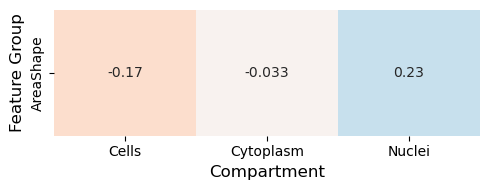

In [8]:
n_row = compartment_feature_group_df.shape[0]
n_col = compartment_feature_group_df.shape[1]
fig_width = n_row + 4
fig_height = 2

plt.figure(figsize = (fig_width, fig_height))

f = sns.heatmap(
    compartment_feature_group_df,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
    annot=True,
    cbar=None,
)

f.set(xlabel="Compartment", ylabel="Feature Group")

f.xaxis.label.set_size(12)
f.yaxis.label.set_size(12)
plt.tight_layout()
plt.savefig("figures/YAP1_subset_area_size_compartment_2.png")
plt.savefig("figures/YAP1_subset_area_size_compartment_2.svg")

In [9]:
channel_feature_group_df = pd.DataFrame()

for channel in channels:
    for feature_group in feature_group_list:
        feature_cols = (
            feature_name_interpretation_df.query("feature_group==@feature_group")
            .query("channel==@channel")
            .feature.to_list()
        )
        feature_values_cluster1 = np.median(orf_profiles_with_feature_names_df.query('Metadata_Symbol in @Cluster1')[feature_cols].copy().values, axis=0)
        feature_values_cluster2 = np.median(orf_profiles_with_feature_names_df.query('Metadata_Symbol in @Cluster2')[feature_cols].copy().values, axis=0)
        feature_values = np.asarray([feature_values_cluster1, feature_values_cluster2])
        id = ["Cluster1", "Cluster2"]

        cosine_sim = utils.cosine_similarity(id, feature_values).values[0, 1]

        df = pd.DataFrame(
            {
                "Channel": channel,
                "Feature_group": feature_group,
                "Similarity": cosine_sim,
            },
            index=[0],
        )

        channel_feature_group_df = pd.concat(
            [channel_feature_group_df, df], ignore_index=True
        )

channel_feature_group_df = channel_feature_group_df.pivot(
    index="Feature_group", columns="Channel", values="Similarity"
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
print(channel_feature_group_df.to_markdown())

| Feature_group      |        AGP |       DNA |         ER |       Mito |       RNA |
|:-------------------|-----------:|----------:|-----------:|-----------:|----------:|
| Intensity          |  0.266764  | -0.245224 |  0.336093  |  0.657489  | -0.102328 |
| RadialDistribution |  0.415869  | -0.17871  | -0.0637685 | -0.0752135 | -0.251699 |
| Texture            | -0.0432892 |  0.664666 |  0.616442  |  0.731464  | -0.143485 |


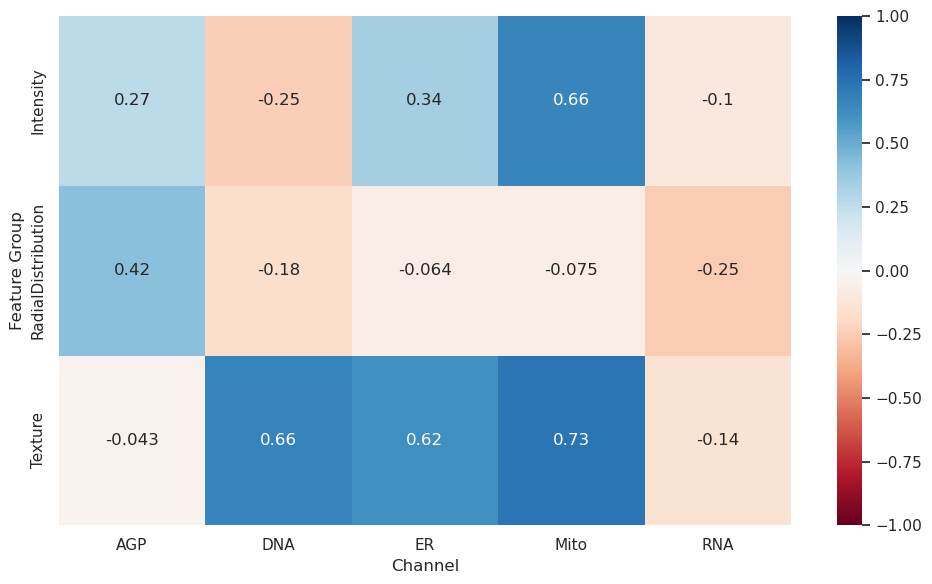

In [11]:
sns.set(font_scale=1)
plt.figure(figsize = (fig_width*2, fig_height*3))


f = sns.heatmap(
    channel_feature_group_df,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
    annot=True,
)

f.set(xlabel="Channel", ylabel="Feature Group")

f.xaxis.label.set_size(12)
f.yaxis.label.set_size(12)
plt.tight_layout()
plt.savefig("figures/YAP1_subset_feature_group_channel_2.png")
plt.savefig("figures/YAP1_subset_feature_group_channel_2.svg")

In [12]:
channels = ["DNA", "AGP", "Mito", "ER", "RNA"]
channel_perturbation_df = pd.DataFrame()
overwrite = False

In [13]:
orf_profiles_with_feature_names_df

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_4,BR00123509,L20,JCP2022_911211,IL20RB,-0.563251,-0.862735,0.445112,-0.414350,0.380735,...,0.529176,0.514146,0.518515,0.506228,0.494304,0.504328,0.507001,0.525635,0.502346,0.501010
1,source_4,BR00123512,L20,JCP2022_914885,CEP72,0.548199,0.188778,-0.950712,0.300605,-1.119493,...,0.447367,0.496191,0.434973,0.455197,0.427364,0.439026,0.452588,0.478226,0.435276,0.448613
2,source_4,BR00123517,K06,JCP2022_903759,MTMR9,-0.401887,-0.809722,0.246457,-0.187846,0.432983,...,-1.072471,-1.122554,-1.081995,-1.098696,-1.092506,-1.062355,-1.086086,-1.069842,-1.079226,-1.081295
3,source_4,BR00123947,D09,JCP2022_911603,RBM26,-1.703838,-1.663814,-0.599653,-1.604465,-0.291192,...,-0.687624,-0.757461,-0.688682,-0.679659,-0.712527,-0.698766,-0.687573,-0.661167,-0.694949,-0.696891
4,source_4,BR00123962,N22,JCP2022_901487,SSBP1,-1.444015,-1.606282,-1.161384,0.970663,-0.894243,...,-1.039182,-0.935711,-1.041095,-1.040212,-1.059501,-1.049994,-1.063058,-1.069612,-1.033122,-1.060136
5,source_4,BR00126390,G23,JCP2022_911451,SPATA7,-0.480541,-0.129038,-1.148374,0.542031,-1.046682,...,0.582416,0.612465,0.586342,0.558310,0.566485,0.591369,0.558152,0.561043,0.559185,0.571564
6,source_4,BR00126520,G07,JCP2022_907106,YAP1,1.606215,2.225155,0.369793,-0.549316,0.141265,...,-0.937797,-0.958488,-1.034979,-1.001840,-1.041748,-0.984161,-0.978684,-0.960774,-0.990483,-0.959312


In [14]:
channel_perturbation_df = (
    orf_profiles_with_feature_names_df[
        [
            "Metadata_JCP2022",
            "Metadata_Source",
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_Symbol",
        ]
    ]
    .copy()
    .assign(pert_type="trt", modality="ORF")
)

channel_perturbation_df

,Metadata_JCP2022,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Symbol,pert_type,modality
0,JCP2022_911211,source_4,BR00123509,L20,IL20RB,trt,ORF
1,JCP2022_914885,source_4,BR00123512,L20,CEP72,trt,ORF
2,JCP2022_903759,source_4,BR00123517,K06,MTMR9,trt,ORF
3,JCP2022_911603,source_4,BR00123947,D09,RBM26,trt,ORF
4,JCP2022_901487,source_4,BR00123962,N22,SSBP1,trt,ORF
5,JCP2022_911451,source_4,BR00126390,G23,SPATA7,trt,ORF
6,JCP2022_907106,source_4,BR00126520,G07,YAP1,trt,ORF


In [15]:
# Add a Lucifersase well from the YAP1 plate

YAP1_plate = channel_perturbation_df.query(
    'Metadata_Symbol == "YAP1"'
).Metadata_Plate.values[0]

well = pd.read_csv("../datasets/metadata/well.csv.gz").query(
    "Metadata_Plate == @YAP1_plate"
).merge(orf_metadata_df, on="Metadata_JCP2022").query('Metadata_Symbol=="LUCIFERASE"')

well = well.sample(1, random_state=12527).assign(pert_type="negcon", modality="ORF")

channel_perturbation_df = pd.concat(
    [channel_perturbation_df, well], ignore_index=True
)

channel_perturbation_df

,Metadata_JCP2022,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Symbol,pert_type,modality
0,JCP2022_911211,source_4,BR00123509,L20,IL20RB,trt,ORF
1,JCP2022_914885,source_4,BR00123512,L20,CEP72,trt,ORF
2,JCP2022_903759,source_4,BR00123517,K06,MTMR9,trt,ORF
3,JCP2022_911603,source_4,BR00123947,D09,RBM26,trt,ORF
4,JCP2022_901487,source_4,BR00123962,N22,SSBP1,trt,ORF
5,JCP2022_911451,source_4,BR00126390,G23,SPATA7,trt,ORF
6,JCP2022_907106,source_4,BR00126520,G07,YAP1,trt,ORF
7,JCP2022_915130,source_4,BR00126520,J02,LUCIFERASE,negcon,ORF


In [16]:
df = pd.DataFrame()

for channel in channels:
    df = pd.concat(
        [
            df,
            channel_perturbation_df.assign(channel=channel),
        ],
        ignore_index=True,
    )

channel_perturbation_df = df.copy()
channel_perturbation_df

,Metadata_JCP2022,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Symbol,pert_type,modality,channel
0,JCP2022_911211,source_4,BR00123509,L20,IL20RB,trt,ORF,DNA
1,JCP2022_914885,source_4,BR00123512,L20,CEP72,trt,ORF,DNA
2,JCP2022_903759,source_4,BR00123517,K06,MTMR9,trt,ORF,DNA
3,JCP2022_911603,source_4,BR00123947,D09,RBM26,trt,ORF,DNA
4,JCP2022_901487,source_4,BR00123962,N22,SSBP1,trt,ORF,DNA
5,JCP2022_911451,source_4,BR00126390,G23,SPATA7,trt,ORF,DNA
6,JCP2022_907106,source_4,BR00126520,G07,YAP1,trt,ORF,DNA
7,JCP2022_915130,source_4,BR00126520,J02,LUCIFERASE,negcon,ORF,DNA
8,JCP2022_911211,source_4,BR00123509,L20,IL20RB,trt,ORF,AGP
9,JCP2022_914885,source_4,BR00123512,L20,CEP72,trt,ORF,AGP


Add Batch information to the metadata

In [17]:
plate_df = pd.read_csv("../datasets/metadata/plate.csv.gz", usecols=["Metadata_Batch", "Metadata_Plate"])

channel_perturbation_df = channel_perturbation_df.merge(plate_df, on="Metadata_Plate", how="left")

channel_perturbation_df

,Metadata_JCP2022,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Symbol,pert_type,modality,channel,Metadata_Batch
0,JCP2022_911211,source_4,BR00123509,L20,IL20RB,trt,ORF,DNA,2021_05_17_Batch4
1,JCP2022_914885,source_4,BR00123512,L20,CEP72,trt,ORF,DNA,2021_05_17_Batch4
2,JCP2022_903759,source_4,BR00123517,K06,MTMR9,trt,ORF,DNA,2021_05_17_Batch4
3,JCP2022_911603,source_4,BR00123947,D09,RBM26,trt,ORF,DNA,2021_06_07_Batch5
4,JCP2022_901487,source_4,BR00123962,N22,SSBP1,trt,ORF,DNA,2021_06_07_Batch5
5,JCP2022_911451,source_4,BR00126390,G23,SPATA7,trt,ORF,DNA,2021_08_02_Batch10
6,JCP2022_907106,source_4,BR00126520,G07,YAP1,trt,ORF,DNA,2021_08_09_Batch11
7,JCP2022_915130,source_4,BR00126520,J02,LUCIFERASE,negcon,ORF,DNA,2021_08_09_Batch11
8,JCP2022_911211,source_4,BR00123509,L20,IL20RB,trt,ORF,AGP,2021_05_17_Batch4
9,JCP2022_914885,source_4,BR00123512,L20,CEP72,trt,ORF,AGP,2021_05_17_Batch4


Download images from S3

In [18]:
if overwrite:
    # os.system("rm -rf images")
    # os.system("mkdir images")
    for jcpid in channel_perturbation_df.Metadata_JCP2022.unique():
        os.system(f"mkdir images/{jcpid}")
    utils.download_images(channel_perturbation_df)

Create Montage

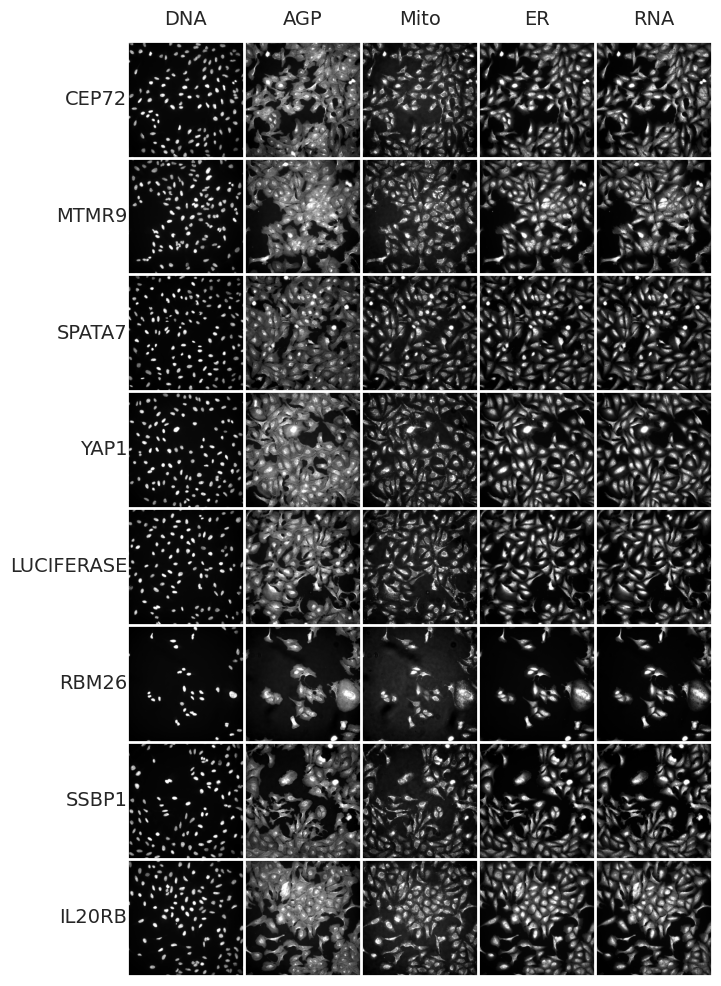

In [19]:
images = []
row_labels = []
col_labels = channels

for gene in Cluster1+["LUCIFERASE"]+Cluster2:
    row_labels.append(gene)
    for channel in channels:
        df = channel_perturbation_df.query(f"Metadata_Symbol == '{gene}' and channel == '{channel}'")
        perturbation = df.Metadata_JCP2022.unique()[0]
        for row in df.itertuples():
            filename = (
                f"images/{perturbation}/{perturbation}_{channel}.tiff"
            )
            img = skimage.io.imread(filename)
            img = utils.brighten_contrast_stretch(img, 1, 99)
            images.append(img)

grid_shape = (channel_perturbation_df.Metadata_JCP2022.nunique(), len(channels))

fig = utils.create_facet_grid_montage(
    images, row_labels, col_labels, grid_shape,
)

# Display the figure
plt.show()

#Save the figure
fig.savefig("figures/facet_grid_montage_YAP1_2.png", dpi=600, bbox_inches="tight")
fig.savefig("figures/facet_grid_montage_YAP1_2.pdf", dpi=600, bbox_inches="tight")

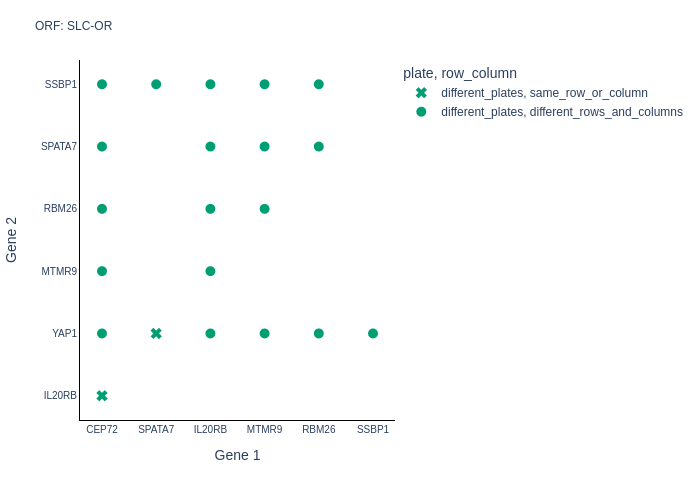

In [20]:
results = pd.DataFrame()
df = (
    orf_profiles_with_feature_names_df.query("Metadata_Symbol in @genes")
    .sort_values(
        by=["Metadata_Symbol", "Metadata_Plate", "Metadata_Well"], ascending=True
    )[["Metadata_Symbol", "Metadata_Plate", "Metadata_Well"]]
    .drop_duplicates(subset=["Metadata_Symbol"], keep="first")
    .assign(Metadata_Row=lambda x: x["Metadata_Well"].str[0])
    .assign(Metadata_Column=lambda x: x["Metadata_Well"].str[1:])
    .reset_index(drop=True)
)[["Metadata_Symbol", "Metadata_Plate", "Metadata_Row", "Metadata_Column"]]


for i in range(len(df)):
    for j in range(i + 1, len(df)):
        if df.loc[i, "Metadata_Plate"] == df.loc[j, "Metadata_Plate"]:
            plate = "same_plate"
        else:
            plate = "different_plates"

        if (
            df.loc[i, "Metadata_Row"] == df.loc[j, "Metadata_Row"]
            or df.loc[i, "Metadata_Column"] == df.loc[j, "Metadata_Column"]
        ):
            row_column = "same_row_or_column"
        else:
            row_column = "different_rows_and_columns"

        results = pd.concat(
            [
                results,
                pd.DataFrame(
                    {
                        "Gene_1": [df.loc[i, "Metadata_Symbol"]],
                        "Gene_2": [df.loc[j, "Metadata_Symbol"]],
                        "plate": [plate],
                        "row_column": [row_column],
                    }
                ),
            ],
            ignore_index=True,
        )

fig = (
    px.scatter(
        results,
        x="Gene_1",
        y="Gene_2",
        color="plate",
        symbol="row_column",
        color_discrete_map=color_discrete_map,
        symbol_map=symbol_map,
    )
    .update_layout(
        title=dict(text=f"ORF: SLC-OR", font=dict(size=12)),
        xaxis=dict(title="Gene 1", linecolor="black", tickfont=dict(size=10)),
        yaxis=dict(title="Gene 2", linecolor="black", tickfont=dict(size=10)),
        plot_bgcolor="white",
    )
    .update_traces(marker=dict(size=10))
)
fig.show("png")
fig.write_image(f"figures/ORF-plate-layout-YAP1_2.png", height=480, width=640, scale=2)
fig.write_image(f"figures/ORF-plate-layout-YAP1_2.svg", height=480, width=640, scale=2)